# Time Series Forecasting

In [2]:
!pip install pystan==2.19.1.1 prophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 4.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for pystan: filename=pystan-2.19.1.1-cp311-cp311-macosx_13_0_arm64.whl size=29450528 sha256=69b57704540db616f55ebffdb3dfa339349fb4686678a7b854706b64f892b69c
  Stored in directory: /Users/Christopher.Merry/Library/Caches/pip/wheels/64/c0/9d/4a4407389d24c0c0dbbc43a84039fcf77841f0312057281cfc
Successfully built pystan


In [18]:
import os
import sys
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import reverse_geocoder as rg
from pyspark.sql.functions import substring, to_timestamp, year, month, dayofmonth, col, mean, to_date, avg, lit, concat, lpad
from pyspark.sql.window import Window
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [2]:
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable


In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("TimeSeriesForecasting") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/09 08:53:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load parquet files
Each file contains data for a single location

In [6]:
# load parquet files
parquet_path = '/Users/Christopher.Merry/Documents/personal/dsc/232/group/232_Project/data/'
df = spark.read.parquet(parquet_path)


## Preprocessing

In [7]:
initial_count = df.count()
print(initial_count)


1361578159


In [8]:
df.printSchema()
df.show(truncate=False)

root
 |-- location_id: long (nullable = true)
 |-- sensors_id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lat.1: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- lon.1: double (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: double (nullable = true)

+-----------+----------+----------------+-------------------------+---------+-----+-----------+-----+---------+-----+-----+
|location_id|sensors_id|location        |datetime                 |lat      |lat.1|lon        |lon.1|parameter|units|value|
+-----------+----------+----------------+-------------------------+---------+-----+-----------+-----+---------+-----+-----+
|615        |1077      |Queen Valley-615|2016-03-10T01:00:00-07:00|33.289398|NULL |-111.292801|NULL |o3       |ppm  |0.04 |
|615        |1077      |Queen Valley-615|2016-03-11T08:00:00-07:00|33.289398|N

### Filter out Latitude = Longitude
Some rows are for locations that have the exact same longitude and latitude, which shouldn't be.

The names of these places are often for locations not in the US. We'll filter them out.

In [9]:
# find rows where latitude and longitude are the exact same
count_lat_long_same = df.filter(F.col('lat') == F.col('lon')).count()

formatted_count = f"{count_lat_long_same:,}"
percentage = (count_lat_long_same / initial_count) * 100
formatted_percentage = f"{percentage:.2f}%"

print(f"Number of rows where lat and long are the same: {formatted_count} ({formatted_percentage})")


Number of rows where lat and long are the same: 22,054,700 (1.62%)


In [10]:
# filter out rows where lat and lon are equal
df = df.filter(F.col('lat') != F.col('lon'))

### Pollutants and their Units

- we'll examine the pollutants and their units, and remove some we aren't interested in.
- we'll also align things like the PM25's µg/m³ units:  µ (micro sign, Unicode: U+00B5) and μ (Greek letter mu, Unicode: U+03BC) are different characters. 

In [11]:
# drop some variants of pm25 we aren't interested in
df = df.filter((F.col('parameter') != 'pm25') | (F.col('units') != 'ppm'))

# any units of 'ppb' have scant rows
df = df.filter(F.col('units') != 'ppb')

# any rows with units of 'particles/cm3' we aren't interested in
df = df.filter(F.col('units') != 'particles/cm³')

# filter out some other pollutants we're not interested in
df = df.filter(~F.col('parameter').isin(['pm25-old', 'ch4', 'bc', 'nox', 'voc', 'no', 'co2', 'pm4']))

# align ug/m3 units
# NOTE: the string values below for ug/m3 should not be touched, retyped, etc. The micro/mu are specific characters that look the same, but are different
df = df.withColumn('units', F.when(F.col('units') == 'μg/m³', 'µg/m³').otherwise(F.col('units')))

#### Convert Temperatures in C to F

In [12]:
# convert temperatures with units C to F
df = df.withColumn('value',
    F.when((F.col('parameter') == 'temperature') & (F.col('units') == 'c'),
        (F.col('value') * 1.8) + 32)
        .otherwise(F.col('value')
    )
)

# change all units to F when parameter is 'temperature'
df = df.withColumn('units', F.when(F.col('parameter') == 'temperature', 'f').otherwise(F.col('units')))

#### Change Pressure Units

In [13]:
# 1 hectopascal equals 1 millibar, so we'll just change the units to mb
df = df.withColumn('units', F.when(F.col('units') == 'hpa', 'mb').otherwise(F.col('units')))

#### Convert units for some pollutants

**NOTE**: skipping this for now. Conversions vary depending on factors, and for now we'll concetrate on rows with the proper units

- for some pollutants, there are measurements in both ug/m3 and ppm
- the AQI calculator (EPA algorithm) expects that pollutants have certain units:
  - CO - ppm *
  - NO2 - ppb *
  - O3 - ppm *
  - PM10 - ug/m3
  - PM25 - ug/m3
  - SO2 - ppb *
- starred units need conversion in this dataset

In [14]:
# TODO: from web research, the converions between ug/m3 and ppb can be quite different depending on temp and pressure, etc. For now, we'll just only use rows with the proper units.

# get a few rows where parameter is 'co' and unit is 'ug/m3'
# z = df.filter((F.col('parameter') == 'co') & (F.col('units') == 'µg/m³')).limit(5)

# NOTE: For now, removing rows with improper units
df = df.filter(~(F.col('parameter').isin(['co', 'no2', 'so2']) & (F.col('units') == 'µg/m³')))

In [15]:
# convert no2 and so2 to ppb
df = df.withColumn('value',
    F.when(
        (F.col('parameter').isin(['so2', 'no2'])) & (F.col('units') == 'ppm'),
        F.col('value') * 1000)
        .otherwise(F.col('value')
    )
)
df = df.withColumn('units',
    F.when(
        (F.col('parameter').isin(['so2', 'no2'])) & (F.col('units') == 'ppm'),
        'ppb')
        .otherwise(F.col('units')
    )
)

### Date
Convert a string column to a date data type and extract date components

In [19]:
# Extract the date part (first 10 characters) and convert to date
df = df.withColumn("date_str", substring("datetime", 1, 10))
df = df.withColumn("date", to_date("date_str", "yyyy-MM-dd"))

# Drop the intermediate date_str column if not needed
df = df.drop("date_str", "datetime")


In [20]:
# Count the number of rows with null values in the 'date' column
null_count = df.filter(col("date").isNull()).count()

print(f"Number of rows with null 'date' values: {null_count}")


Number of rows with null 'date' values: 0


In [21]:
# Drop rows where 'date' column has null values and overwrite the original DataFrame
df = df.dropna(subset=["date"])

# Extract year, month, and day
df = df.withColumn("year", year("date")) \
       .withColumn("month", month("date")) \
       .withColumn("day", dayofmonth("date"))


### Geocode

We'll Geocode the latitude and longitude values to:

- cull locations that aren't in the US
- use the added categorical geographic information (State, City, etc) in analysis

In [22]:
def geocode(locations_dict):
    
    # get list of lat, lon tuples from coords dict
    coords = [(row['coords'][0], row['coords'][1]) for row in locations_dict.values()]

    # reverse geocode
    geocode_results = rg.search(coords)

    geocode_results = [{'city': loc['name'], 'state': loc['admin1'], 'country_code': loc['cc']} for loc in geocode_results]
    results = []
    for (key, _), loc in zip(locations_dict.items(), geocode_results):
        results.append((int(key), loc['city'], loc['state'], str.lower(loc['country_code'])))

    return results

# create a UDF with a map(string, string) return type (e.g. {country_code -> 'US'})
geocode_udf = F.udf(geocode, T.MapType(T.StringType(), T.StringType()))

In [23]:
# create dataframe of just distinct locations and their lat, lon
locations = df.groupBy('location_id').agg(F.first('lat').alias('lat'), F.first('lon').alias('lon')).collect()

# setup dictionary, where key is location_id, and value is a tuple of (lat, lon)
locations = {row['location_id']: {'coords': (row['lat'], row['lon'])} for row in locations}

# reverse geocode
locations = geocode(locations)

# create spark dataframe of results
schema = T.StructType([
    T.StructField('location_id', T.LongType(), True),
    T.StructField('city', T.StringType(), True),
    T.StructField('state', T.StringType(), True),
    T.StructField('country_code', T.StringType(), True)
])
geocoded_df = spark.createDataFrame(locations, schema=schema)

# join this dataframe with the original dataframe
df = df.join(geocoded_df, on='location_id', how='left')


Loading formatted geocoded file...


#### Drop rows that are not in the United States

In [24]:
df = df.filter((F.col('country_code')) == 'us')

### Drop unused columns

Some source files have errant lat.1 and lon.1 columns. They are all NULL for all rows, and can be safely dropped.

In [25]:
df = df.drop('lat.1', 'lon.1', 'sensors_id', 'location_id', 'location')

In [26]:
df.printSchema()

root
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: double (nullable = true)
 |-- date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country_code: string (nullable = true)



### Check nulls and types

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when

# Count nulls in each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Get data types
data_types = [(c, t) for c, t in df.dtypes]

# Convert data types to DataFrame
data_types_df = spark.createDataFrame(data_types, ["column", "type"])

# Convert null counts to DataFrame
null_counts_df = null_counts.collect()[0].asDict()
null_counts_list = [(k, v) for k, v in null_counts_df.items()]
null_counts_df = spark.createDataFrame(null_counts_list, ["column", "null_count"])

# Join data types and null counts DataFrames
summary_df = data_types_df.join(null_counts_df, on="column")

# Show the summary DataFrame
summary_df.show(25)


+------------+------+----------+
|      column|  type|null_count|
+------------+------+----------+
|        city|string|         0|
|country_code|string|         0|
|        date|  date|         0|
|         day|   int|         0|
|         lat|double|         0|
|         lon|double|         0|
|       month|   int|         0|
|   parameter|string|         0|
|       state|string|         0|
|       units|string|         0|
|       value|double|         0|
|        year|   int|         0|
+------------+------+----------+



### Pivot Data

In [28]:
# Pivot the data to create columns for each pollutant type and calculate the mean value
pivoted_df = df.groupBy("city", "state", "country_code", "date") \
                        .pivot("parameter", ["o3", "pm10", "pm25", "co", "so2", "no2"]) \
                        .agg(mean("value").alias("mean_value"))

### AQI Scores

In [29]:
import aqi

def calculate_aqi(pm10, pm25, co, no2, o3, so2):

    try:
        pollutants = []

        pollutants.append((aqi.POLLUTANT_PM10, pm10)) if pm10 else None
        pollutants.append((aqi.POLLUTANT_PM25, pm25)) if pm25 else None
        pollutants.append((aqi.POLLUTANT_CO_8H, co)) if co else None
        pollutants.append((aqi.POLLUTANT_NO2_1H, no2)) if no2 else None
        pollutants.append((aqi.POLLUTANT_O3_8H, o3)) if o3 else None
        pollutants.append((aqi.POLLUTANT_SO2_1H, so2)) if so2 else None

        return(float(aqi.to_aqi(pollutants)))

    except Exception as e:
        return None
# -------------------------------

# register UDF
aqi_udf = F.udf(calculate_aqi, T.FloatType())

# add AQI column
pivoted_df = pivoted_df.withColumn('aqi', aqi_udf(F.col('pm10'), F.col('pm25'), F.col('co'), F.col('no2'), F.col('o3'), F.col('so2')))

In [30]:
def aqi_category(aqi_score):
    if aqi_score is None:
        return None
    elif aqi_score <= 50:
        return "Good"
    elif aqi_score <= 100:
        return "Moderate"
    elif aqi_score <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi_score <= 200:
        return "Unhealthy"
    elif aqi_score <= 300:
        return "Very Unhealthy"
    elif aqi_score > 300:
        return "Hazardous"
    else:
        return None

# register UDF
aqi_category_udf = F.udf(aqi_category, T.StringType())

pivoted_df = pivoted_df.withColumn("aqi_category", aqi_category_udf(F.col("aqi")))

## Cache Dataframe

In [31]:
pivoted_df.cache()
pivoted_df.count()

24/06/09 09:11:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/09 09:11:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/09 09:11:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/09 09:11:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/09 09:11:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/09 09:11:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/09 09:11:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/09 09:11:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/09 09:11:23 WARN RowBasedKeyValueBatch: Calling spill() on

3612969

In [32]:
# Group by 'aqi_category' and count the occurrences
pivoted_df.groupBy("aqi_category").count().show()


+--------------------+-------+
|        aqi_category|  count|
+--------------------+-------+
|           Unhealthy|   6757|
|                NULL|  39428|
|                Good|3230633|
|Unhealthy for Sen...|  11957|
|           Hazardous|    433|
|            Moderate| 322864|
|      Very Unhealthy|    897|
+--------------------+-------+



In [33]:
# Drop rows where 'aqi_category' column has null values and overwrite the original DataFrame
pivoted_df = pivoted_df.dropna(subset=["aqi_category"])


## Write dataframes to parquet files

In [ ]:
# Save the DataFrame to Parquet format
df.write.parquet("/Users/Christopher.Merry/Documents/personal/dsc/232/group/232_Project/milestone4_processed_data/df.parquet")
pivoted_df.write.parquet("/Users/Christopher.Merry/Documents/personal/dsc/232/group/232_Project/milestone4_pivoted_data/pivoted_df.parquet")


### Read processed dataframes
This is used when restarting analysis without having to redo all the preprocessing

In [ ]:
# load parquet files
parquet_path = '/Users/Christopher.Merry/Documents/personal/dsc/232/group/232_Project/milestone4_processed_data/'
df = spark.read.parquet(parquet_path)

parquet_path = '/Users/Christopher.Merry/Documents/personal/dsc/232/group/232_Project/milestone4_pivoted_data/'
pivoted_df = spark.read.parquet(parquet_path)


## Analysis

### Create 30 day rolling windows
Compare the daily average to a 30 day rolling average to see how individual means compare to the values around it

In [34]:
# Define the window specification with partitioning by 'city' and 'state'
window_spec = Window.partitionBy("city", "state").orderBy("date").rowsBetween(-30, 0)  # 30-day rolling window

# Calculate the rolling average for a selected pollutant
pivoted_df = pivoted_df.withColumn("pm25_rolling_avg", avg(col("pm25")).over(window_spec))

# Show the results
pivoted_df.select("date", "city", "state", "pm25", "pm25_rolling_avg").show(truncate=False)


+----------+-----------+----------+-------------------+------------------+
|date      |city       |state     |pm25               |pm25_rolling_avg  |
+----------+-----------+----------+-------------------+------------------+
|2023-10-03|Acres Green|Colorado  |7.799036144578313  |7.799036144578313 |
|2023-10-07|Acres Green|Colorado  |1.2322321428571417 |4.515634143717727 |
|2024-03-10|Acres Green|Colorado  |0.4365196078431376 |3.1559292984261975|
|2024-03-11|Acres Green|Colorado  |0.27993421052631584|2.436930526451227 |
|2023-10-03|Aguanga    |California|3.3100972326103233 |3.3100972326103233|
|2023-10-07|Aguanga    |California|3.1127951256664126 |3.2114461791383677|
|2024-03-10|Aguanga    |California|2.412937062937063  |2.9452764737379327|
|2024-03-11|Aguanga    |California|3.519897959183674  |3.088931845099368 |
|2023-10-03|Alexander  |Arkansas  |16.073287671232894 |16.073287671232894|
|2023-10-07|Alexander  |Arkansas  |3.183220338983051  |9.628254005107973 |
|2024-03-10|Alexander  |A

### Forecasting Using Prophet with PySpark
Prophet is popular library for time series forecasting, developed by Facebook. However, it operates on Pandas DataFrames. To use it with PySpark, we can split the process: aggregate the data with PySpark and then perform forecasting with Prophet.

The complete process involved first aggregating the data using PySpark, and then converting it to a Pandas DataFrame for use with Prophet. This way, we are leveraging PySpark's distributed processing capabilities for data preparation, and Prophet's time series forecasting capabilities for prediction.

Prophet generates predictions for both the historical data and the future dates specified (30 days into the future in this example). The plot includes both the fitted values for the historical data and the predictions for the future dates.

### Create Model (pm25)
<p>As a first run, we create a model based on pm25 only
<p>The model will predict values for 30 days into the future, and it plots the actual historical data (black), along with predictions (blue).

00:19:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:55 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


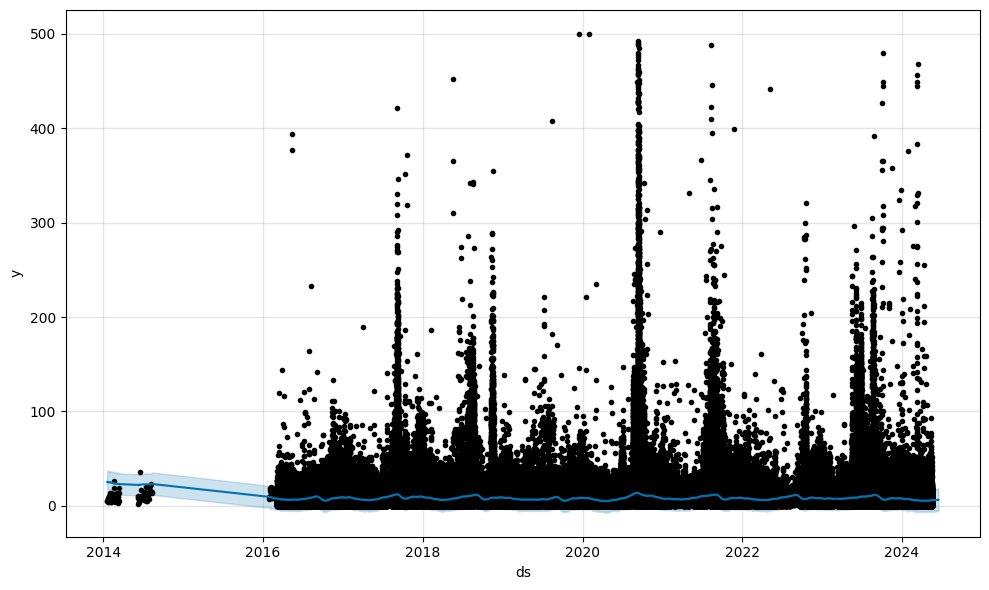

In [42]:
pdf = pivoted_df.select("date", "pm25").toPandas()

# Prepare data for Prophet
pdf = pdf.rename(columns={"date": "ds", "pm25": "y"})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(pdf)

# Create a dataframe to hold predictions
# Predict 30 days into the future
future = model.make_future_dataframe(periods=30)  

# Make predictions
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

#### Plot 6 months of single pollutant (pm25)
Now plot 6 months of historical data to better compare forecasted series.  The forecast does not look very impressive.  It is basically a flat line.  Maybe this is due to the pollutant chosen.

10:01:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:37 - cmdstanpy - INFO - Chain [1] done processing


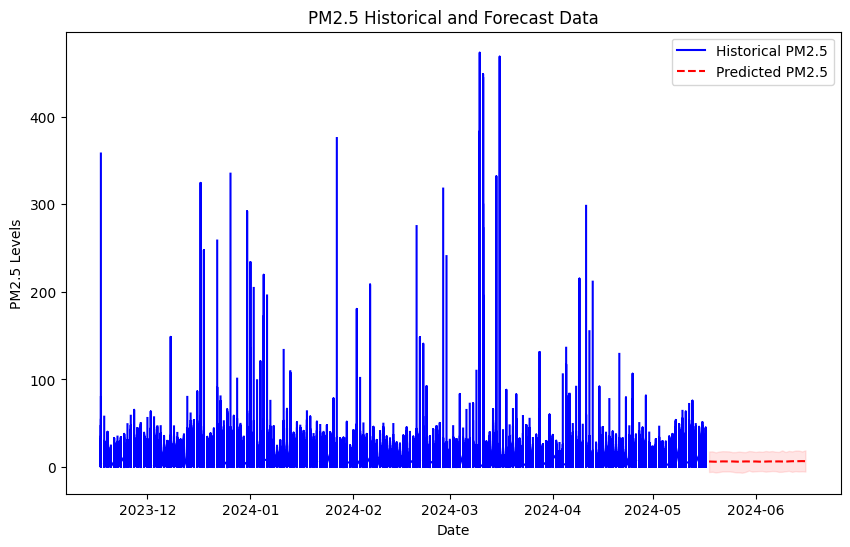

In [40]:
# Convert date column to DateType
pivoted_df = pivoted_df.withColumn("date", to_date(col("date")))

# Convert to Pandas DataFrame
pdf = pivoted_df.select("date", "pm25").toPandas()

# Prepare data for Prophet
pdf = pdf.rename(columns={"date": "ds", "pm25": "y"})

# Ensure 'ds' column is in datetime format
pdf['ds'] = pd.to_datetime(pdf['ds'])

# Initialize and fit the Prophet model
model = Prophet()
model.fit(pdf)

# Create a dataframe to hold predictions
# Predict 30 days into the future
future = model.make_future_dataframe(periods=30)

# Make predictions
forecast = model.predict(future)

# Filter to include only the last 6 months of historical data
end_date = pdf['ds'].max()
start_date = end_date - pd.DateOffset(months=6)
historical_data = pdf[(pdf['ds'] >= start_date) & (pdf['ds'] <= end_date)]

# Filter future forecast to include only future dates
future_forecast = forecast[forecast['ds'] > end_date]

# Sort the historical data and future forecast data by date
historical_data = historical_data.sort_values(by='ds')
future_forecast = future_forecast.sort_values(by='ds')

# Plot the combined historical and future forecast data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(historical_data['ds'], historical_data['y'], label='Historical PM2.5', color='blue', linestyle='-')

# Plot predicted data
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicted PM2.5', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='red', alpha=0.1)

plt.title('PM2.5 Historical and Forecast Data')
plt.xlabel('Date')
plt.ylabel('PM2.5 Levels')
plt.legend()
plt.show()


### Refine plot
We made adjustments to the pm25 plot before expanding to include other pollutants

00:27:38 - cmdstanpy - INFO - Chain [1] start processing                        
00:33:03 - cmdstanpy - INFO - Chain [1] done processing


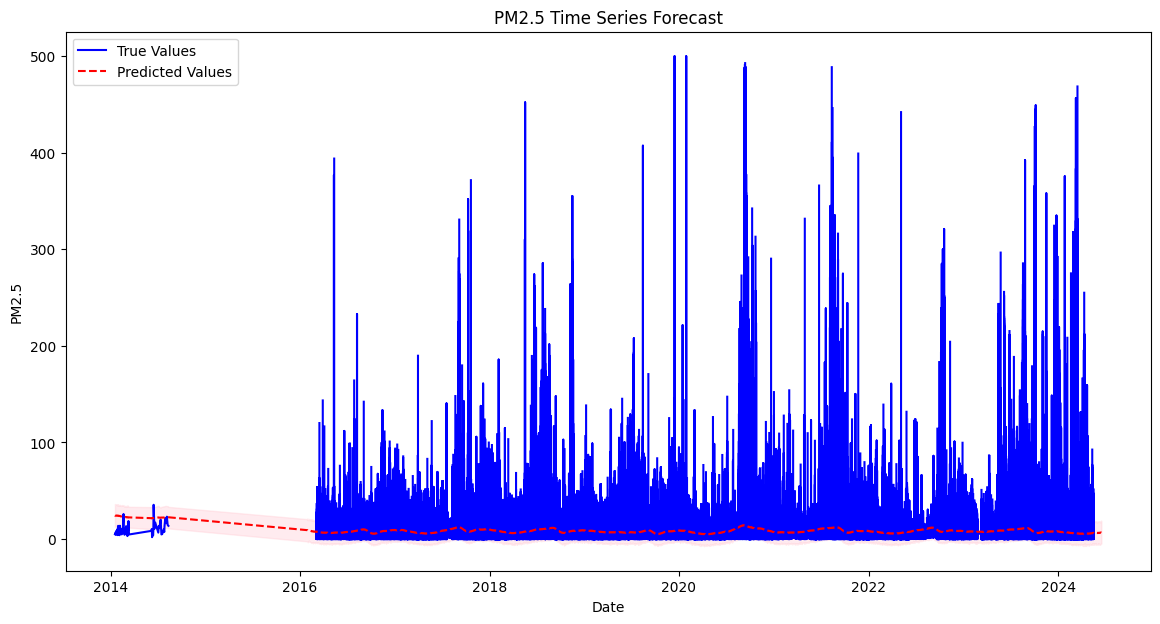

In [44]:
pdf = pivoted_df.select("date", "pm25").orderBy("date").toPandas()

# Prepare data for Prophet
pdf = pdf.rename(columns={"date": "ds", "pm25": "y"})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(pdf)

# Create a dataframe to hold predictions
future = model.make_future_dataframe(periods=30)  # Predict 30 days into the future

# Make predictions
forecast = model.predict(future)

# Plot the true values and the forecast
plt.figure(figsize=(14, 7))

# Plot true values
plt.plot(pdf['ds'], pdf['y'], label='True Values', color='blue', linestyle='-')

# Plot predicted values
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Values', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

plt.title('PM2.5 Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


### Now plot all pollutants
Obviously this was pretty messy, so the next step will break out each pollutant individually

00:37:53 - cmdstanpy - INFO - Chain [1] start processing
00:38:39 - cmdstanpy - INFO - Chain [1] done processing
00:39:48 - cmdstanpy - INFO - Chain [1] start processing                        
00:44:46 - cmdstanpy - INFO - Chain [1] done processing
00:45:10 - cmdstanpy - INFO - Chain [1] start processing
00:47:19 - cmdstanpy - INFO - Chain [1] done processing
00:48:19 - cmdstanpy - INFO - Chain [1] start processing                        
00:53:02 - cmdstanpy - INFO - Chain [1] done processing
00:53:20 - cmdstanpy - INFO - Chain [1] start processing
00:53:36 - cmdstanpy - INFO - Chain [1] done processing
00:53:49 - cmdstanpy - INFO - Chain [1] start processing
00:54:20 - cmdstanpy - INFO - Chain [1] done processing


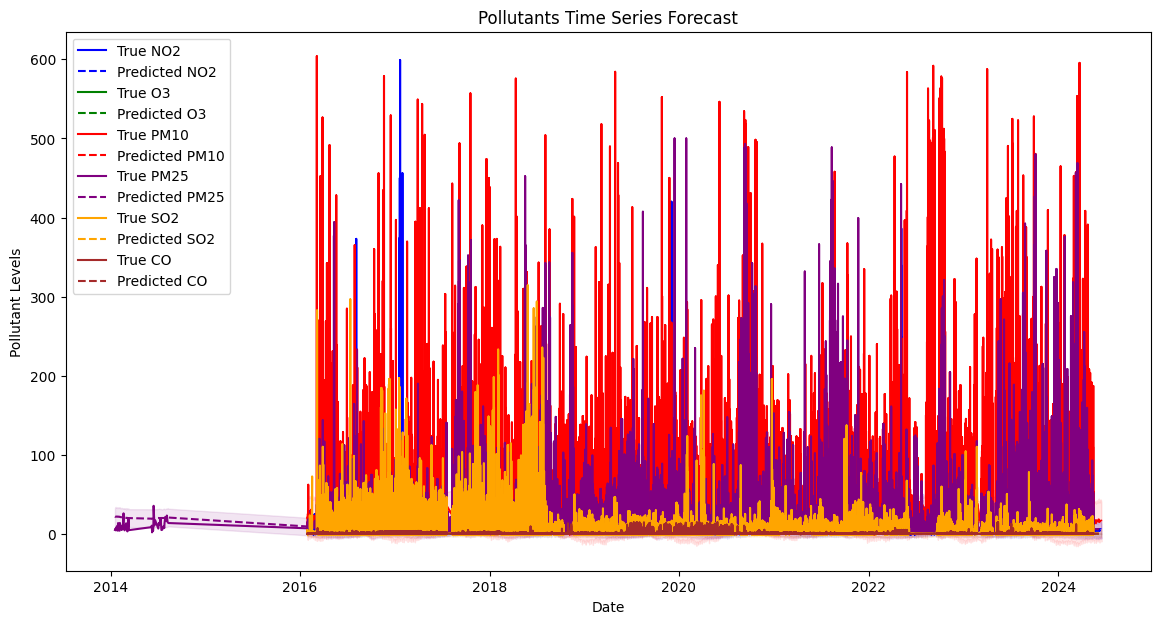

In [45]:
# List of pollutants to analyze
pollutants = ["no2", "o3", "pm10", "pm25", "so2", "co"]

# Prepare a plot
plt.figure(figsize=(14, 7))

# Colors and styles for different pollutants
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
styles = ['-', '--', '-.', ':', '-', '--']

for i, pollutant in enumerate(pollutants):
    # Filter relevant columns and convert to Pandas DataFrame
    pollutant_df = pivoted_df.select("date", pollutant).filter(col(pollutant).isNotNull()).orderBy("date").toPandas()

    # Prepare data for Prophet
    pollutant_df = pollutant_df.rename(columns={"date": "ds", pollutant: "y"})

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(pollutant_df)

    # Create a dataframe to hold predictions
    future = model.make_future_dataframe(periods=30)  # Predict 30 days into the future

    # Make predictions
    forecast = model.predict(future)

    # Plot the true values
    plt.plot(pollutant_df['ds'], pollutant_df['y'], label=f'True {pollutant.upper()}', color=colors[i], linestyle=styles[0])

    # Plot the predicted values
    plt.plot(forecast['ds'], forecast['yhat'], label=f'Predicted {pollutant.upper()}', color=colors[i], linestyle=styles[1])

    # Plot confidence intervals
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color=colors[i], alpha=0.1)

# Customize the plot
plt.title('Pollutants Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Pollutant Levels')
plt.legend()
plt.show()


### Plot Individual Pollutants

01:13:42 - cmdstanpy - INFO - Chain [1] start processing
01:14:28 - cmdstanpy - INFO - Chain [1] done processing
01:15:36 - cmdstanpy - INFO - Chain [1] start processing                        
01:20:26 - cmdstanpy - INFO - Chain [1] done processing
01:20:52 - cmdstanpy - INFO - Chain [1] start processing                        
01:23:00 - cmdstanpy - INFO - Chain [1] done processing
01:23:58 - cmdstanpy - INFO - Chain [1] start processing                        
01:28:41 - cmdstanpy - INFO - Chain [1] done processing
01:28:58 - cmdstanpy - INFO - Chain [1] start processing
01:29:14 - cmdstanpy - INFO - Chain [1] done processing
01:29:28 - cmdstanpy - INFO - Chain [1] start processing
01:29:58 - cmdstanpy - INFO - Chain [1] done processing


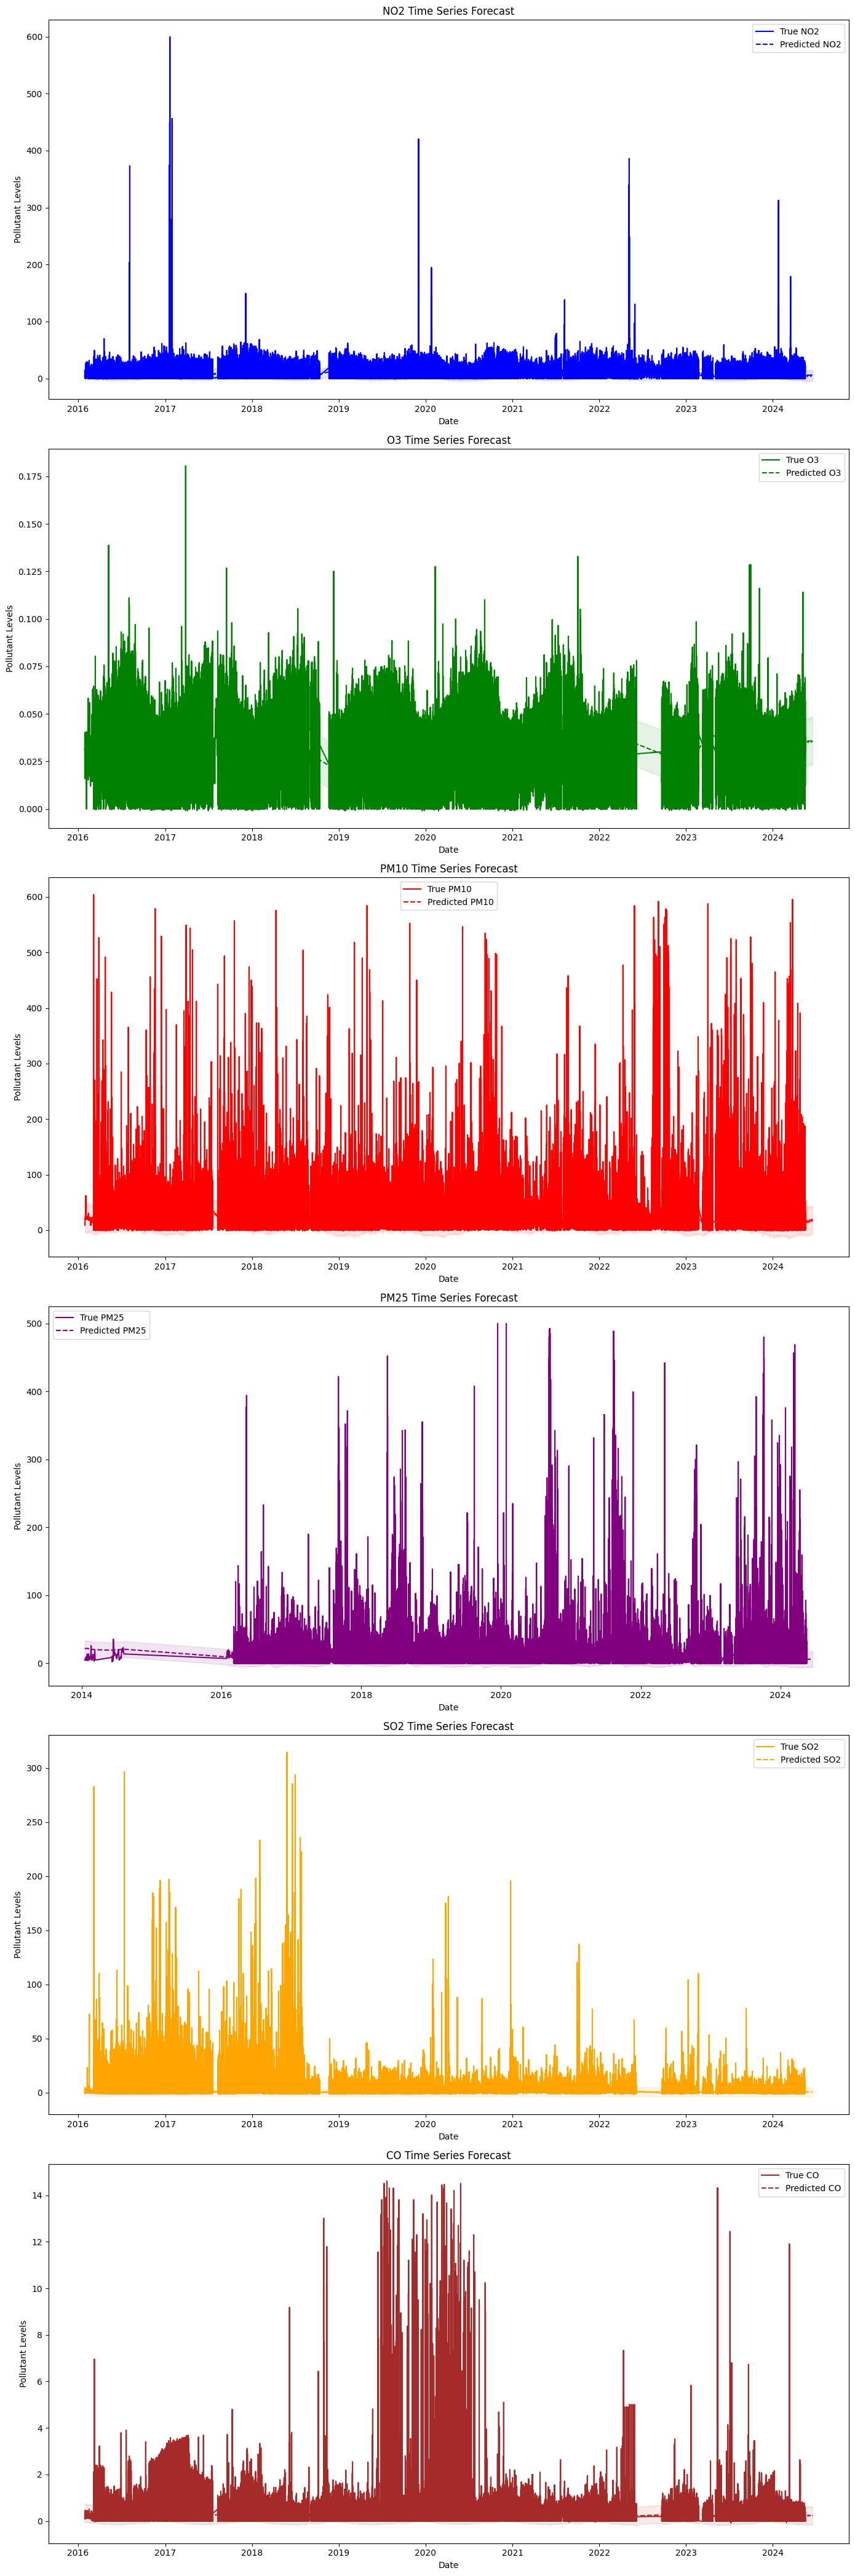

In [47]:
# List of pollutants to analyze
pollutants = ["no2", "o3", "pm10", "pm25", "so2", "co"]

# Prepare subplots
fig, axes = plt.subplots(len(pollutants), 1, figsize=(14, 7 * len(pollutants)))

for i, pollutant in enumerate(pollutants):
    # Filter relevant columns and convert to Pandas DataFrame
    pollutant_df = pivoted_df.select("date", pollutant).filter(col(pollutant).isNotNull()).orderBy("date").toPandas()

    # Prepare data for Prophet
    pollutant_df = pollutant_df.rename(columns={"date": "ds", pollutant: "y"})

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(pollutant_df)

    # Create a dataframe to hold predictions
    future = model.make_future_dataframe(periods=30)  # Predict 30 days into the future

    # Make predictions
    forecast = model.predict(future)

    # Plot the true values
    axes[i].plot(pollutant_df['ds'], pollutant_df['y'], label=f'True {pollutant.upper()}', color='blue', linestyle='-')

    # Plot the predicted values
    axes[i].plot(forecast['ds'], forecast['yhat'], label=f'Predicted {pollutant.upper()}', color='red', linestyle='--')

    # Plot confidence intervals
    axes[i].fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1)

    # Customize each subplot
    axes[i].set_title(f'{pollutant.upper()} Time Series Forecast')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Pollutant Levels')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Plot Individual Pollutants with Monthly Mean and Confidence Interval
To help illustrate how time series forecasting compares to historical data, we calculated a monthly mean value for each pollutant.  This made it much more clear how historical values compared to predicted values.  We also included confidence intervals for predicted values to further identify effectiveness of the model.

01:44:30 - cmdstanpy - INFO - Chain [1] start processing
01:44:30 - cmdstanpy - INFO - Chain [1] done processing
01:44:30 - cmdstanpy - INFO - Chain [1] start processing
01:44:30 - cmdstanpy - INFO - Chain [1] done processing
01:44:31 - cmdstanpy - INFO - Chain [1] start processing
01:44:31 - cmdstanpy - INFO - Chain [1] done processing
01:44:31 - cmdstanpy - INFO - Chain [1] start processing
01:44:31 - cmdstanpy - INFO - Chain [1] done processing
01:44:32 - cmdstanpy - INFO - Chain [1] start processing
01:44:32 - cmdstanpy - INFO - Chain [1] done processing
01:44:32 - cmdstanpy - INFO - Chain [1] start processing
01:44:33 - cmdstanpy - INFO - Chain [1] done processing


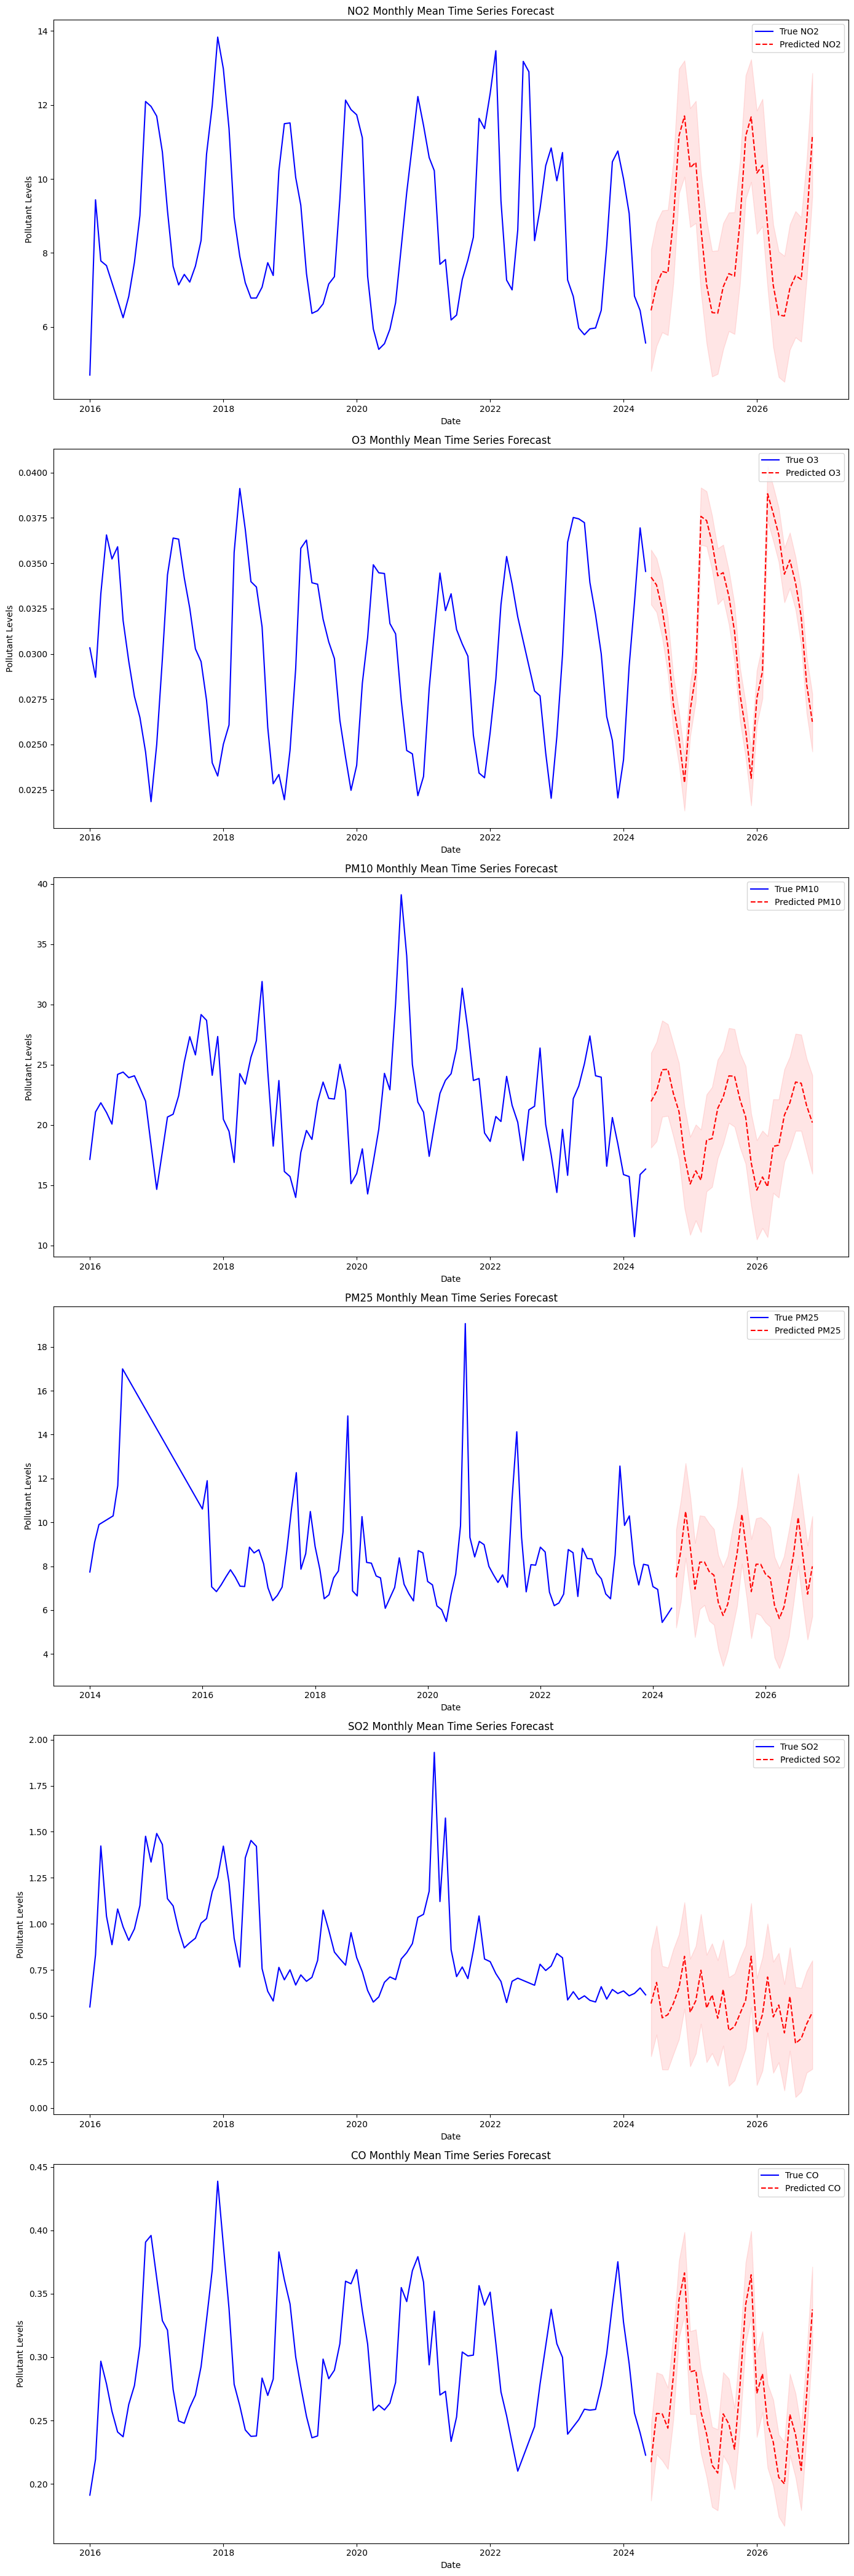

In [64]:
# List of pollutants to analyze
pollutants = ["no2", "o3", "pm10", "pm25", "so2", "co"]

# Prepare subplots
fig, axes = plt.subplots(len(pollutants), 1, figsize=(14, 7 * len(pollutants)))

for i, pollutant in enumerate(pollutants):
    # Calculate monthly mean for each pollutant
    monthly_mean_df = pivoted_df.withColumn('month', month(col('date'))) \
                                .withColumn('year', year(col('date'))) \
                                .groupBy('year', 'month') \
                                .agg(avg(col(pollutant)).alias(pollutant)) \
                                .orderBy('year', 'month')
    
    # Convert to Pandas DataFrame
    monthly_mean_df = monthly_mean_df.withColumn("date", concat(col("year").cast("string"), lit("-"), 
                                                                lpad(col("month").cast("string"), 2, '0'), 
                                                                lit("-01")))
    monthly_mean_df = monthly_mean_df.select("date", pollutant).filter(col(pollutant).isNotNull()).orderBy("date").toPandas()
    monthly_mean_df["date"] = pd.to_datetime(monthly_mean_df["date"])

    # Prepare data for Prophet
    monthly_mean_df = monthly_mean_df.rename(columns={"date": "ds", pollutant: "y"})

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(monthly_mean_df)

    # Create a dataframe to hold predictions
    future = model.make_future_dataframe(periods=30, freq='M')  # Predict 30 months into the future

    # Make predictions
    forecast = model.predict(future)

    # Split the forecast into historical and future predictions
    forecast['is_future'] = forecast['ds'] > monthly_mean_df['ds'].max()
    future_forecast = forecast[forecast['is_future']]
    historical_forecast = forecast[~forecast['is_future']]

    # Plot the true values
    axes[i].plot(monthly_mean_df['ds'], monthly_mean_df['y'], label=f'True {pollutant.upper()}', color='blue', linestyle='-')

    # Plot the predicted values for future dates only
    axes[i].plot(future_forecast['ds'], future_forecast['yhat'], label=f'Predicted {pollutant.upper()}', color='red', linestyle='--')

    # Plot confidence intervals for future dates only
    axes[i].fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='red', alpha=0.1)

    # Customize each subplot
    axes[i].set_title(f'{pollutant.upper()} Monthly Mean Time Series Forecast')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Pollutant Levels')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Compare Forecasting Across Three States

02:00:27 - cmdstanpy - INFO - Chain [1] start processing
02:00:27 - cmdstanpy - INFO - Chain [1] done processing
02:00:28 - cmdstanpy - INFO - Chain [1] start processing
02:00:29 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for Texas and no2


02:00:30 - cmdstanpy - INFO - Chain [1] start processing
02:00:30 - cmdstanpy - INFO - Chain [1] done processing
02:00:32 - cmdstanpy - INFO - Chain [1] start processing
02:00:35 - cmdstanpy - INFO - Chain [1] done processing
02:00:36 - cmdstanpy - INFO - Chain [1] start processing
02:00:39 - cmdstanpy - INFO - Chain [1] done processing
02:00:39 - cmdstanpy - INFO - Chain [1] start processing
02:00:40 - cmdstanpy - INFO - Chain [1] done processing
02:00:41 - cmdstanpy - INFO - Chain [1] start processing
02:00:45 - cmdstanpy - INFO - Chain [1] done processing
02:00:45 - cmdstanpy - INFO - Chain [1] start processing
02:00:45 - cmdstanpy - INFO - Chain [1] done processing
02:00:46 - cmdstanpy - INFO - Chain [1] start processing
02:00:46 - cmdstanpy - INFO - Chain [1] done processing
02:00:48 - cmdstanpy - INFO - Chain [1] start processing
02:00:53 - cmdstanpy - INFO - Chain [1] done processing
02:00:54 - cmdstanpy - INFO - Chain [1] start processing                        
02:00:56 - cmds

Not enough data for Texas and so2
Not enough data for New York and co


02:00:58 - cmdstanpy - INFO - Chain [1] start processing
02:00:59 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for Texas and co


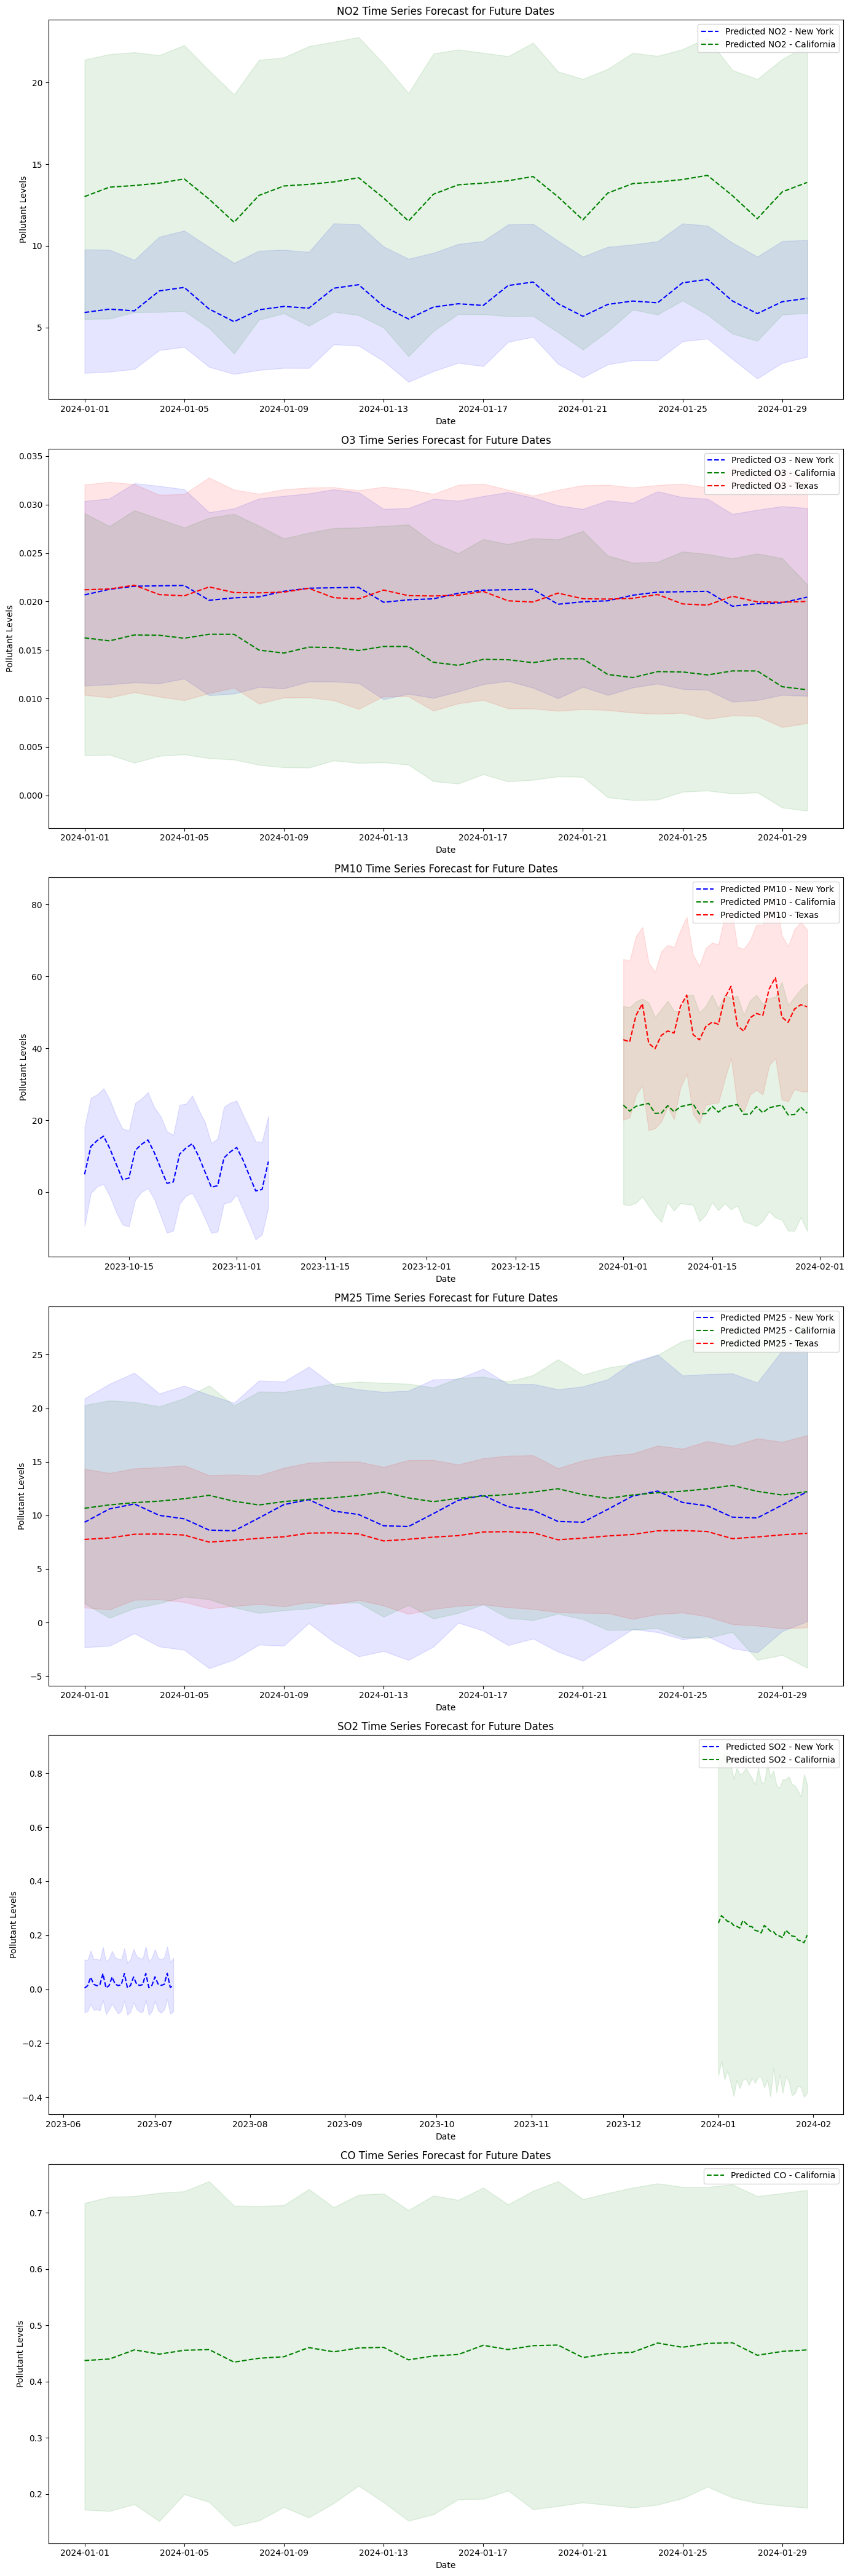

In [75]:
# Filter for the specific states and year 2023
states = ["New York", "California", "Texas"]
filtered_df = pivoted_df.filter((col("state").isin(states)) & (year(col("date")) == 2023))

# List of pollutants to analyze
pollutants = ["no2", "o3", "pm10", "pm25", "so2", "co"]

# Prepare the plot
fig, axes = plt.subplots(len(pollutants), 1, figsize=(14, 7 * len(pollutants)))

# Colors for different states
state_colors = {
    "New York": 'blue',
    "California": 'green',
    "Texas": 'red'
}

for i, pollutant in enumerate(pollutants):
    for state in states:
        # Filter relevant columns and convert to Pandas DataFrame
        pollutant_df = filtered_df.filter((col("state") == state) & (col(pollutant).isNotNull())).select("date", pollutant).orderBy("date").toPandas()

        # Ensure there are at least 2 non-NaN rows before fitting the model
        if pollutant_df.dropna().shape[0] < 2:
            print(f"Not enough data for {state} and {pollutant}")
            continue

        # Prepare data for Prophet
        pollutant_df = pollutant_df.rename(columns={"date": "ds", pollutant: "y"})

        # Ensure 'ds' column is in datetime format
        pollutant_df['ds'] = pd.to_datetime(pollutant_df['ds'])

        # Initialize and fit the Prophet model
        model = Prophet()
        model.fit(pollutant_df)

        # Create a dataframe to hold predictions
        future = model.make_future_dataframe(periods=30)  # Predict 30 days into the future

        # Make predictions
        forecast = model.predict(future)

        # Filter to include only future dates
        max_date = pollutant_df['ds'].max()
        future_forecast = forecast[forecast['ds'] > max_date]

        # Plot the predicted values for future dates only
        axes[i].plot(future_forecast['ds'], future_forecast['yhat'], label=f'Predicted {pollutant.upper()} - {state}', color=state_colors[state], linestyle='--')

        # Plot confidence intervals for future dates only
        axes[i].fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color=state_colors[state], alpha=0.1)

    # Customize each subplot
    axes[i].set_title(f'{pollutant.upper()} Time Series Forecast for Future Dates')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Pollutant Levels')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()
